### Project Title

Wind Power Generation Forecasting Using Machine Learning

### Objective

We want to predict the Power Output (normalized between 0–1) of a wind turbine given meteorological conditions — such as temperature, wind speed, humidity, and wind direction

### Why?
- Because predicting power output helps:

- Grid operators plan electricity distribution

- Wind farm owners optimize turbine operations

- Energy markets forecast available renewable energy

- This is a regression problem — our target (Power) is continuous, not categorical.

### Import Libraries

- pandas: for reading and manipulating data

- numpy: for numerical operations

- matplotlib/seaborn: for visualization

- sklearn: for splitting data, scaling features, training models, and evaluating performance

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


### Load the Dataset

Pick one location first (e.g., Location1.csv) <br> <p>
We start with one location because each location can have its own model due to the fact that wind conditions vary geographically.

In [35]:
df = pd.read_csv("Location1.csv")
df.head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


### Explore the Data

We want to understand:

1. Number of rows and columns

2. Data types (float, int, etc.)

3. Missing values

4. Value ranges

This tells us what preprocessing steps are required (like scaling or filling missing values).

In [36]:
print(df.shape)
print(df.columns)
df.info()
df.describe()

(43800, 10)
Index(['Time', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time                 43800 non-null  object 
 1   temperature_2m       43800 non-null  float64
 2   relativehumidity_2m  43800 non-null  int64  
 3   dewpoint_2m          43800 non-null  float64
 4   windspeed_10m        43800 non-null  float64
 5   windspeed_100m       43800 non-null  float64
 6   winddirection_10m    43800 non-null  int64  
 7   winddirection_100m   43800 non-null  int64  
 8   windgusts_10m        43800 non-null  float64
 9   Power                43800 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 3.3+ MB


,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,47.862911,72.288744,38.569308,3.591147,6.284431,203.637329,203.343676,7.771795,0.405385
std,19.453691,16.852287,18.772110,1.649318,2.685216,96.371262,97.959852,3.569147,0.288322
min,-14.400000,18.000000,-17.100000,0.000000,0.100000,1.000000,0.000000,0.500000,0.000000
25%,32.100000,60.000000,24.300000,2.410000,4.380000,132.000000,130.000000,5.000000,0.148900
50%,47.300000,74.000000,38.100000,3.300000,6.080000,225.000000,226.000000,7.200000,0.347650
75%,64.500000,86.000000,54.700000,4.590000,7.990000,277.000000,278.000000,10.000000,0.659600
max,94.100000,100.000000,76.300000,13.450000,20.650000,360.000000,360.000000,29.200000,0.991300


### Handle Missing Values

ML models don’t handle missing values well — they need complete data. <br>
Median imputation is robust against outliers and works well for numeric data.

In [37]:
print(df.isnull().sum())

# Replace missing numeric values with the column median
#df = df.fillna(df.median())
# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Fill missing numeric values with their column median
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Optionally fill non-numeric columns with mode (most common value)
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
df[non_numeric_cols] = df[non_numeric_cols].fillna(df[non_numeric_cols].mode().iloc[0])



Time                   0
temperature_2m         0
relativehumidity_2m    0
dewpoint_2m            0
windspeed_10m          0
windspeed_100m         0
winddirection_10m      0
winddirection_100m     0
windgusts_10m          0
Power                  0
dtype: int64


### Feature Engineering
The dataset contains wind direction in degrees (0–360), but:

- 0° and 360° represent the same direction, so this isn’t linear.

- We can represent direction using sine and cosine to capture circularity.

Converting directions using sin/cos avoids false discontinuities (e.g., between 0° and 360°). <br>

These features help models capture how direction influences turbine efficiency.

In [38]:
# Convert direction degrees to radians
df['winddir_10m_rad'] = np.deg2rad(df['winddirection_10m'])
df['winddir_100m_rad'] = np.deg2rad(df['winddirection_100m'])

# Convert to sine and cosine components
df['winddir_10m_sin'] = np.sin(df['winddir_10m_rad'])
df['winddir_10m_cos'] = np.cos(df['winddir_10m_rad'])
df['winddir_100m_sin'] = np.sin(df['winddir_100m_rad'])
df['winddir_100m_cos'] = np.cos(df['winddir_100m_rad'])

# Drop the original direction columns
df.drop(['winddirection_10m', 'winddirection_100m', 'winddir_10m_rad', 'winddir_100m_rad'], axis=1, inplace=True)


### Extract time features

We don’t scale or model the Time column directly. Instead, we extract meaningful time features (hour, month, etc.) and then drop the raw text column.

The scaler can’t “standardize” a date string

The raw timestamp itself doesn’t carry useful information to the model.
But its components (hour, day, month, etc.) capture daily and seasonal patterns in wind power:


In [39]:
# Convert Time column to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Extract useful time features
df['hour'] = df['Time'].dt.hour
df['month'] = df['Time'].dt.month
df['dayofweek'] = df['Time'].dt.dayofweek

# Drop the original Time column (non-numeric)
df.drop(columns=['Time'], inplace=True)


### Define Features and Target

X = input features (wind, temperature, humidity, etc.)

y = target we want to predict (turbine power output)

In [40]:
X = df.drop('Power', axis=1)
y = df['Power']


### Split Data

We train the model on 80% of data and test it on 20% unseen data to measure generalization. <br>
Random seed ensures reproducibility.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scale Features

Wind speeds, temperatures, and humidity have different numeric ranges. <br>
Scaling ensures all features contribute equally to the model.
(StandardScaler → mean=0, std=1)


In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Train a Model

Let’s start with a Random Forest Regressor.

Random Forests are robust, nonlinear, and handle feature interactions well.

They automatically capture complex relationships (e.g., how temperature + wind speed affect power).

In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,  # number of trees
    max_depth=None,    # trees grow fully
    random_state=42
)
rf.fit(X_train_scaled, y_train)


### Evaluate the Model

RMSE: how far predictions are from actual values (lower = better). <br>
Essentially RMSE means — “How far off are my predictions?”

Every prediction is a little off — some too high, some too low.

Now:

- RMSE takes all those differences (errors),

- squares them (so negatives don’t cancel out positives),

- averages them,

- and then takes the square root <p>

R²: how much variance the model explains (1 = perfect fit, 0 = no relationship)
Essentially R² means — “How much of the pattern did my model learn?”

R² (R-squared) measures how well your model explains the changes in the data.

R² = 0.76 That means: <br>
Your model can explain about 76% of the changes in power output based on weather conditions.


| Metric          | What It Means                        | How You Did | Plain English                                                       |
| --------------- | ------------------------------------ | ----------- | ------------------------------------------------------------------- |
| **RMSE = 0.14** | Average prediction error (0–1 scale) | Low = good  | “My guesses are usually within about 14% of the true power.”        |
| **R² = 0.76**   | % of data pattern captured           | High = good | “I’ve understood about 3/4 of what causes changes in power output.” |


In [ ]:
y_pred = rf.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)


Root Mean Squared Error: 0.14065430481515986
R² Score: 0.7609300249889654


### Interpret the Model

Feature importance tells us which variables drive turbine power most — usually windspeed_100m or gusts.
This is crucial for operational insights (e.g., “wind speed at 100m explains 80% of output”).

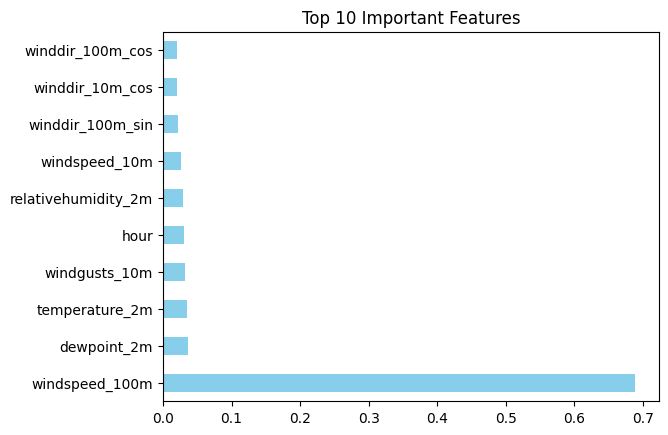

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Important Features")
plt.show()


### Predict on New Data

The trained model can now forecast power for future conditions.

This is the core deliverable of your project.

In [ ]:
import pandas as pd

# Simulated “today’s weather” input for prediction
data = {
    'temperature_2m': [60.0],
    'relativehumidity_2m': [70.0],
    'dewpoint_2m': [52.0],
    'windspeed_10m': [8.5],
    'windspeed_100m': [10.2],
    'winddirection_10m': [240],
    'winddirection_100m': [245],
    'windgusts_10m': [12.1]
}

new_data = pd.DataFrame(data)
new_data.to_csv("new_conditions.csv", index=False)
print("✅ new_conditions.csv created!")


✅ new_conditions.csv created!


In [ ]:
import joblib

# Save the trained Random Forest model
joblib.dump(rf, "rf_model.pkl",compress=3)

# Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")

print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load model and scaler
rf = joblib.load("rf_model.pkl")
scaler = joblib.load("scaler.pkl")

# Load new data
new_data = pd.read_csv("new_conditions.csv")

# -----------------------------
# 1️⃣ Apply the same preprocessing as training
# -----------------------------

# Convert directions to sin/cos (since model used these)
new_data['winddir_10m_rad'] = np.radians(new_data['winddirection_10m'])
new_data['winddir_100m_rad'] = np.radians(new_data['winddirection_100m'])

new_data['winddir_10m_sin'] = np.sin(new_data['winddir_10m_rad'])
new_data['winddir_10m_cos'] = np.cos(new_data['winddir_10m_rad'])
new_data['winddir_100m_sin'] = np.sin(new_data['winddir_100m_rad'])
new_data['winddir_100m_cos'] = np.cos(new_data['winddir_100m_rad'])

# Drop unnecessary columns
new_data = new_data.drop(columns=['winddirection_10m', 'winddirection_100m',
                                  'winddir_10m_rad', 'winddir_100m_rad'])


# -----------------------------
# 2️⃣ Ensure feature alignment
# -----------------------------
# Get column names the model was trained on
trained_features = scaler.feature_names_in_

# Add any missing columns (set them to 0)
for col in trained_features:
    if col not in new_data.columns:
        new_data[col] = 0

# Drop extra columns (keep only what model expects)
new_data = new_data[trained_features]

# -----------------------------
# 3️⃣ Scale & Predict
# -----------------------------
new_scaled = scaler.transform(new_data)
predicted_power = rf.predict(new_scaled)

# -----------------------------
# 4️⃣ Save and display
# -----------------------------
new_data['Predicted_Power'] = predicted_power
new_data.to_csv("predicted_output.csv", index=False)
print("✅ Prediction complete! Check predicted_output.csv")
print(new_data[['Predicted_Power']])


✅ Prediction complete! Check predicted_output.csv
   Predicted_Power
0         0.582354
